# Leave-One-Subject-Out Evaluation

In [12]:
import numpy as np
import cv2
import dlib
from imutils import face_utils
import glob
import pickle
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import yaml
from scipy.spatial import distance as dist
import statistics
import matplotlib.pyplot as plt
import face_alignment

In [13]:
def get_camera_parameters(size):
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )
    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    
    return camera_matrix, dist_coeffs

In [14]:
def get_image_points(landmarks):
    image_points = np.zeros((68, 2))

    for i in range(68):
        image_points[i, :] = (landmarks[i]['x'], landmarks[i]['y'])
    
    return image_points

In [15]:
def get_full_model_points(filename='model_points.txt'):
    """Get all 68 3D model points from file"""
    raw_value = []
    with open(filename) as file:
        for line in file:
            raw_value.append(line)
    model_points = np.array(raw_value, dtype=np.float32)
    model_points = np.reshape(model_points, (3, -1)).T

    # Transform the model into a front view.
    model_points[:, 2] *= -1

    return model_points

In [16]:
def visualize_image(im, rotation_vector, translation_vector, image_points, camera_matrix, dist_coeffs,
                    iris_left, iris_right, label):
    for point in image_points:
        cv2.circle(im, (int(point[0]), int(point[1])), 3, (0, 0, 255), -1)
    cv2.circle(im, (int(iris_left[0]), int(iris_left[1])), 3, (0, 0, 255), -1)
    cv2.circle(im, (int(iris_right[0]), int(iris_right[1])), 3, (0, 0, 255), -1)
    
    # Project the 3D point (0.55592, 6.5629, 300.0) onto the image plane.
    # We use this to draw a line sticking out of the nose
    (nose_end_point2D, jacobian) = cv2.projectPoints(
        np.array([(0.55592, 6.5629, 300.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs
        )
    # Draw a line connecting the two points. This line must show
    # the direction out of the nose
    p1 = ( int(image_points[33][0]), int(image_points[33][1]) )
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]) )
    cv2.line(im, p1, p2, (255,0,0), 2)
    
    # Display image
    cv2.imshow(output, im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [17]:
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean([eye[1]['x'], eye[1]['y']], [eye[5]['x'], eye[5]['y']])
    B = dist.euclidean([eye[2]['x'], eye[2]['y']], [eye[4]['x'], eye[4]['y']])
 
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean([eye[0]['x'], eye[0]['y']], [eye[3]['x'], eye[3]['y']])
 
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
 
    # return the eye aspect ratio
    return ear

***

In [18]:
# Load the dataset
with open('data_cleaned.json') as json_file:
    data_all = json.load(json_file)
# Extract the keys in sorted order
keys_all = sorted(data_all)
# Convert python list to np array
keys_all = np.asarray(keys_all)
# Load all the uuids
participants = glob.glob('dataset/*')

In [19]:
# Define global variables
DATASET_SIZE = len(keys_all)
NUM_FEATURES = 22
NUM_OF_PARTICIPANTS = len(participants)
EAR_THRESHOLD = 0.17
DEBUG = False
MODEL_POINTS = get_full_model_points()

In [20]:
print("""Running attention prediction for {} participants and a total of {} images.
Each participant will be excluded from the training set once, our classifiers 
will be trained on the remaining participants and finally we will predict
the result for the one we left out. The total accuracy will be the mean value
of the accuracies of each participant""".format(NUM_OF_PARTICIPANTS, DATASET_SIZE))

Running attention prediction for 52 participants and a total of 2728 images.
Each participant will be excluded from the training set once, our classifiers 
will be trained on the remaining participants and finally we will predict
the result for the one we left out. The total accuracy will be the mean value
of the accuracies of each participant


In [75]:
# Total weighted metrics, taking into account the size of each participant's dataset
accuracy_rf = []
accuracy_svm = []
precision_rf = []
precision_svm = []
recall_rf = []
recall_svm = []

# Total metrics without taking into account the size of each dataset. That is, calculate
# the metric for each participant and take the mean of the 52 metrics
accuracy_rf_raw = []
accuracy_svm_raw = []
precision_rf_raw = []
precision_svm_raw = []
recall_rf_raw = []
recall_svm_raw = []

# Array to keep track of subjects with low score
low_score_subjects_rf = []
low_score_subjects_svm = []

# Arrays to plot the probabilities with respect to the classes(0 or 1)
positive_probs_rf = []
negative_probs_rf = []
positive_probs_svm = []
negative_probs_svm = []

# Leave one out implementation.
# Loop over each participant and exclude him/her from the dataset each time
for j in range(NUM_OF_PARTICIPANTS):
    
    # Extract the UUID
    uuid_excluded = participants[j].split('/')[1]

    # Loop over the dataset to remove the examples associated with this participant
    indices_excluded = []
    keys_excluded = []
    for i in range(DATASET_SIZE):
        key = keys_all[i]
        uuid = key.split('/')[0]
        if(uuid == uuid_excluded):
            indices_excluded.append(i)
            keys_excluded.append(key)
#     keys = np.delete(keys_all, indices_excluded)
#     CURRENT_DATASET_SIZE = keys.shape[0]

#     # Initialize our training dataset
#     X = np.zeros((CURRENT_DATASET_SIZE, NUM_FEATURES, 1))
#     y = np.zeros(CURRENT_DATASET_SIZE)

#     # Indices where SolvePnP failed
#     failed_indices = []
#     # Indices where the subject blinked
#     blinked_indices = []
    
#     # Loop over each example of the remaining dataset to construct the training set
#     for i in range(CURRENT_DATASET_SIZE):
        
#         # Retrieve the key for this example
#         key = keys[i]
        
# #         # Uncomment to use pose estimation from PRNet
# #         prnet_key = 'prnet/' + key.split('.')[0]
# #         rotation_vector = np.reshape(np.loadtxt(prnet_key + '_rvec.txt'), (3, 1))
# #         translation_vector = np.reshape(np.loadtxt(prnet_key + '_tvec.txt'), (3, 1))
        
#         # Read the image and save the size
#         im = cv2.imread('dataset/' + key)
#         size = im.shape
            
#         # Get the 68 facial landmarks
#         landmarks = data_all[key]['landmarks']
        
#         # Use the above landmarks to generate image points in the 
#         # form that solvePnP() takes as input
#         image_points = get_image_points(landmarks)
        
#         # Get camera parameters to feed into solvePnP()
#         camera_matrix, dist_coeffs = get_camera_parameters(size)

#         # Solve the PnP problem with the parameters specified above
#         # and obtain rotation and translation vectors
#         (success, rotation_vector, translation_vector) = cv2.solvePnP(
#             MODEL_POINTS, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
#             )
        
#         # Iris location features
#         iris_right = np.reshape(np.asarray(data_all[key]['iris_right']), (2, 1))
#         iris_left = np.reshape(np.asarray(data_all[key]['iris_left']), (2, 1))

#         # Difference vector features
#         left_vector = np.asarray( (abs(iris_left[0] - landmarks[39]['x']), abs(iris_left[1] - landmarks[39]['y'])) )
#         right_vector = np.asarray( (abs(iris_right[0] - landmarks[42]['x']), abs(iris_right[1] - landmarks[42]['y'])) )
        
#         # Concatenate all the above features to create a training example
#         X[i, :] = np.concatenate((rotation_vector, translation_vector, iris_left, iris_right, 
#                                  left_vector, right_vector, np.reshape(image_points[0, :], (2, 1)),
#                                                             np.reshape(image_points[8, :], (2, 1)),
#                                                             np.reshape(image_points[16, :], (2, 1)),
#                                                             np.reshape(image_points[33, :], (2, 1))), axis=0)

#         # Check if it is positive or negative example and set the groundtruth value accordingly
#         output = key.split('/')[1]
#         if(output == 'positive'):
#             y[i] = 1
#         elif(output == 'negative'):
#             y[i] = 0
    
#         # Blink Detection
#         leftEAR = eye_aspect_ratio(landmarks[36:42])
#         rightEAR = eye_aspect_ratio(landmarks[42:48])
#         ear = (leftEAR + rightEAR) / 2.0
#         if(ear <= EAR_THRESHOLD):
#             blinked_indices.append(i)
            
#         # Remove examples that SolvePnP crashed
#         if(X[i, 0] > 10000 or not success):
#             print(key)
#             failed_indices.append(i)
            
#     # Delete indices that solvePnP failed to solve correctly
#     X = np.delete(X, failed_indices, axis=0)
#     y = np.delete(y, failed_indices, axis=0)
#     # Blink detection: Remove the blinked examples from the training phase. 
#     # There is no need to train the classifiers on them as they will be detected in advance
#     X = np.delete(X, blinked_indices, axis=0)
#     y = np.delete(y, blinked_indices, axis=0)
    
#     # Reshape from (CURRENT_DATASET_SIZE, NUM_FEATURES, 1)
#     # to           (CURRENT_DATASET_SIZE, NUM_FEATURES, )  for compatibility reasons
#     X = X.squeeze()
    
#     # Normalize features to have 0 mean and 1 variance
#     m = X.mean(axis=0)
#     std = X.std(axis=0)
#     X_scaled = (X - m)/std
    
#     # Train the classifiers
#     X_train, y_train = X_scaled, y

#     rf_classifier = RandomForestClassifier(n_estimators=500, random_state=1)
#     rf_classifier.fit(X_train, y_train)

#     svm_classifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True) # For probabilities
# #     svm_classifier = svm.SVC(C=10, kernel='rbf', gamma='scale')
#     svm_classifier.fit(X_train, y_train)

# ### Uncomment below to save classifiers in pickle files so there is no need to train every time
#     with open('classifiers/22_features/rf/' + uuid_excluded + '.pickle', 'wb') as f:
#         pickle.dump(rf_classifier, f, pickle.HIGHEST_PROTOCOL)
#     with open('classifiers/22_features/svm/' + uuid_excluded + '.pickle', 'wb') as f:
#         pickle.dump(svm_classifier, f, pickle.HIGHEST_PROTOCOL)

### Uncomment below to retrieve classifiers from the saved pickle files
    with open('classifiers/22_features/rf/' + uuid_excluded + '.pickle', 'rb') as f:
        rf_classifier = pickle.load(f)
    with open('classifiers/22_features/svm/' + uuid_excluded + '.pickle', 'rb') as f:
        svm_classifier = pickle.load(f)

### End of training phase, continue with the validation set ###

    # Construct the validation dataset consisting of examples of a single participant
    # Evaluation of the classifiers will be done on this dataset
    X_eval = np.zeros((len(keys_excluded), NUM_FEATURES, 1))
    y_eval = np.zeros(len(keys_excluded))
    
    # Indices where the subject blinked
    blinked_indices = []
    
    # Perform the same steps as the consturction of the training dataset
    for i in range(len(keys_excluded)):
        key = keys_excluded[i]
        
#         # Uncomment to use pose estimation from PRNet
#         prnet_key = 'prnet/' + key.split('.')[0]     
#         rotation_vector = np.reshape(np.loadtxt(prnet_key + '_rvec.txt'), (3, 1))
#         translation_vector = np.reshape(np.loadtxt(prnet_key + '_tvec.txt'), (3, 1))
        
        uuid = key.split('/')[0]
        
        im = cv2.imread('dataset/' + key)
        size = im.shape

        landmarks = data_all[key]['landmarks']
        
        camera_matrix, dist_coeffs = get_camera_parameters(size)
        
        image_points = get_image_points(landmarks)

        (success, rotation_vector, translation_vector) = cv2.solvePnP(
            MODEL_POINTS, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
            )

        iris_right = np.reshape(np.asarray(data_all[key]['iris_right']), (2, 1))
        iris_left = np.reshape(np.asarray(data_all[key]['iris_left']), (2, 1))
        left_vector = np.asarray( (abs(iris_left[0] - landmarks[39]['x']), abs(iris_left[1] - landmarks[39]['y'])) )
        right_vector = np.asarray( (abs(iris_right[0] - landmarks[42]['x']), abs(iris_right[1] - landmarks[42]['y'])) )

        X_eval[i, :] = np.concatenate((rotation_vector, translation_vector, iris_left, iris_right, 
                                 left_vector, right_vector, np.reshape(image_points[0, :], (2, 1)),
                                                            np.reshape(image_points[8, :], (2, 1)),
                                                            np.reshape(image_points[16, :], (2, 1)),
                                                            np.reshape(image_points[33, :], (2, 1))), axis=0)
        output = key.split('/')[1]
        if(output == 'positive'):
            y_eval[i] = 1
        elif(output == 'negative'):
            y_eval[i] = 0
        
        # Blink Detection
        leftEAR = eye_aspect_ratio(landmarks[36:42])
        rightEAR = eye_aspect_ratio(landmarks[42:48])
        ear = (leftEAR + rightEAR) / 2.0
        if(ear <= EAR_THRESHOLD):
            blinked_indices.append(i)
            # Show the blinked examples in debug mode
            if DEBUG:
                visualize_image(im, rotation_vector, translation_vector, image_points, camera_matrix,
                           dist_coeffs, iris_left, iris_right, output)

    X_eval = X_eval.squeeze()
    
    # Number of the examples that we predicted as blink
    predicted_blinks = len(blinked_indices)
    # Counter that counts how many of the predicted blinks are true blinks
    true_blinks = 0
    # Loop over each predicted blink
    for k in blinked_indices:
        # If the groundtruth is Negative our prediction was true <- Approximation
        if y_eval[k] == 0:
            true_blinks += 1

    # Remove the blinked examples from the validation set after the computations
    X_eval = np.delete(X_eval, blinked_indices, axis=0)
    y_eval = np.delete(y_eval, blinked_indices, axis=0)
    
    # Feature Normalization
    m_eval = X_eval.mean(axis=0)
    std_eval = X_eval.std(axis=0)
    X_eval = (X_eval - m_eval)/std_eval
    
    # Predict Random Forest
    threshold_rf = 0.4
    y_prob_rf = rf_classifier.predict_proba(X_eval)
    y_pred_rf = (y_prob_rf[:, 1] >= threshold_rf).astype(int)
    rf_accuracy_subject = metrics.accuracy_score(y_eval, y_pred_rf)
    # For the overall accuracy of each subject we must take into consideration the blink accuracy too
    rf_accuracy_subject = (rf_accuracy_subject*X_eval.shape[0] + true_blinks)/(X_eval.shape[0] + predicted_blinks)

    # Predict SVM
    threshold_svm = 0.3
    y_prob_svm = svm_classifier.predict_proba(X_eval)
    y_pred_svm = (y_prob_svm[:, 1] >= threshold_svm).astype(int)
#     y_pred_svm = svm_classifier.predict(X_eval)
    svm_accuracy_subject = metrics.accuracy_score(y_eval, y_pred_svm)
    # For the overall accuracy of each subject we must take into consideration the blink accuracy too
    svm_accuracy_subject = (svm_accuracy_subject*X_eval.shape[0] + true_blinks)/(X_eval.shape[0] + predicted_blinks)
    
#     # Keep track of the probabilities each time in order to plot them and 
#     # get an intuition for the prediction thresholds
    negative_indices = (y_eval == 0)
    negative_probs_rf = negative_probs_rf + list(y_prob_rf[negative_indices, 1])
    negative_probs_svm = negative_probs_svm + list(y_prob_svm[negative_indices, 1])
    positive_indices = (y_eval == 1)
    positive_probs_rf = positive_probs_rf + list(y_prob_rf[positive_indices, 1])
    positive_probs_svm = positive_probs_svm + list(y_prob_svm[positive_indices, 1])
    
    # From the confusion matrix of the 2 classifiers calculate precision and recall
    #### Note that the blinked examples will not be inlucded in the calculations
    confusion_matrix_rf = metrics.confusion_matrix(y_eval, y_pred_rf)
    confusion_matrix_svm = metrics.confusion_matrix(y_eval, y_pred_svm)
    precision_rf_subject = confusion_matrix_rf[1][1]/(confusion_matrix_rf[1][1] + confusion_matrix_rf[0][1])
    recall_rf_subject = confusion_matrix_rf[1][1]/(confusion_matrix_rf[1][1] + confusion_matrix_rf[1][0])
    precision_svm_subject = confusion_matrix_svm[1][1]/(confusion_matrix_svm[1][1] + confusion_matrix_svm[0][1])
    recall_svm_subject = confusion_matrix_svm[1][1]/(confusion_matrix_svm[1][1] + confusion_matrix_svm[1][0])
    
    print('RF  #{} Accuracy: {} | Precision: {} | Recall: {}'.format(j, round(rf_accuracy_subject,3),
                                                            round(precision_rf_subject,2), round(recall_rf_subject, 2)))
    print('SVM #{} Accuracy: {} | Precision: {} | Recall: {}'.format(j, round(svm_accuracy_subject, 3),
                                                            round(precision_svm_subject, 2), round(recall_svm_subject, 2)))
    
    # Keep track of the participants that performed poorly for debbuging purposes
    if(rf_accuracy_subject <= 0.5):
        low_score_subjects_rf.append(uuid_excluded)
        with open('classifiers/lowscore/rf/' + uuid_excluded + '.pickle', 'wb') as f:
            pickle.dump(rf_classifier, f, pickle.HIGHEST_PROTOCOL)
    if(svm_accuracy_subject <= 0.5):
        low_score_subjects_svm.append(uuid_excluded)
        with open('classifiers/lowscore/svm/' + uuid_excluded + '.pickle', 'wb') as f:
            pickle.dump(svm_classifier, f, pickle.HIGHEST_PROTOCOL)
    
    # Calculate the total metrics by mulitiplying each metric with the
    # number of examples of its dataset and in the end divide by
    # the total number of examples
    accuracy_rf_raw.append(rf_accuracy_subject)
    accuracy_svm_raw.append(svm_accuracy_subject)
    precision_rf_raw.append(precision_rf_subject)
    precision_svm_raw.append(precision_svm_subject)
    recall_rf_raw.append(recall_rf_subject)
    recall_svm_raw.append(recall_svm_subject)
    
    accuracy_rf.append(rf_accuracy_subject*len(keys_excluded))
    accuracy_svm.append(svm_accuracy_subject*len(keys_excluded))
    precision_rf.append(precision_rf_subject*len(keys_excluded))
    precision_svm.append(precision_svm_subject*len(keys_excluded))
    recall_rf.append(recall_rf_subject*len(keys_excluded))
    recall_svm.append(recall_svm_subject*len(keys_excluded))

accuracy_rf_total = sum(accuracy_rf)/DATASET_SIZE
accuracy_svm_total = sum(accuracy_svm)/DATASET_SIZE
precision_rf_total = sum(precision_rf)/DATASET_SIZE
precision_svm_total = sum(precision_svm)/DATASET_SIZE
recall_rf_total = sum(recall_rf)/DATASET_SIZE
recall_svm_total = sum(recall_svm)/DATASET_SIZE

RF  #0 Accuracy: 0.697 | Precision: 0.79 | Recall: 0.65
SVM #0 Accuracy: 0.848 | Precision: 0.93 | Recall: 0.82
RF  #1 Accuracy: 0.871 | Precision: 0.95 | Recall: 0.86
SVM #1 Accuracy: 0.774 | Precision: 0.94 | Recall: 0.73
RF  #2 Accuracy: 0.864 | Precision: 0.85 | Recall: 0.92
SVM #2 Accuracy: 0.864 | Precision: 0.85 | Recall: 0.92
RF  #3 Accuracy: 0.769 | Precision: 0.8 | Recall: 0.89
SVM #3 Accuracy: 0.462 | Precision: 0.62 | Recall: 0.56
RF  #4 Accuracy: 0.73 | Precision: 0.77 | Recall: 0.77
SVM #4 Accuracy: 0.649 | Precision: 0.71 | Recall: 0.68
RF  #5 Accuracy: 0.808 | Precision: 0.78 | Recall: 0.86
SVM #5 Accuracy: 0.808 | Precision: 0.83 | Recall: 0.78
RF  #6 Accuracy: 0.929 | Precision: 1.0 | Recall: 0.88
SVM #6 Accuracy: 0.643 | Precision: 0.74 | Recall: 0.58
RF  #7 Accuracy: 0.871 | Precision: 0.83 | Recall: 0.91
SVM #7 Accuracy: 0.935 | Precision: 0.93 | Recall: 0.93
RF  #8 Accuracy: 0.897 | Precision: 0.85 | Recall: 1.0
SVM #8 Accuracy: 0.872 | Precision: 0.91 | Recall: 0

In [76]:
print('Total Accuracy RF:  {}'.format(accuracy_rf_total))
print('Total Accucary SVM: {}'.format(accuracy_svm_total))

Total Accuracy RF:  0.7800586510263929
Total Accucary SVM: 0.7521994134897361


In [77]:
print('Precision RF: {}'.format(precision_rf_total))
print('Precision SVM: {}'.format(precision_svm_total))

Precision RF: 0.8041299985747229
Precision SVM: 0.8089126390282246


In [78]:
print('Recall RF: {}'.format(recall_rf_total))
print('Recall SVM: {}'.format(recall_svm_total))

Recall RF: 0.8422185287151148
Recall SVM: 0.7472936040767476


In [79]:
print(len(low_score_subjects_rf))
print(len(low_score_subjects_svm))

1
5


In [81]:
file1 = open("low_score_rf.txt", "w") 
for i in low_score_subjects_rf:
    file1.write(i + '\n')
    
file2 = open("low_score_svm.txt", "w")
for i in low_score_subjects_svm:
    file2.write(i + '\n')

Text(0, 0.5, 'Random Forest probability for positives')

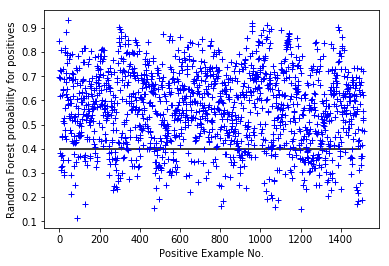

In [82]:
plt.figure(1)
plt.plot(positive_probs_rf, 'b+')
plt.hlines(0.4, 0, 1500, label='threshold')
plt.xlabel('Positive Example No.')
plt.ylabel('Random Forest probability for positives')

Text(0, 0.5, 'Random Forest probability for negatives')

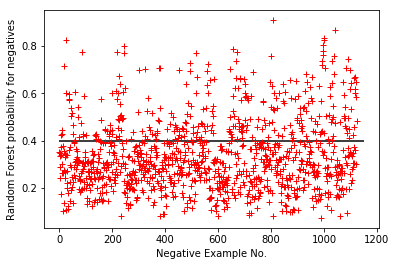

In [83]:
plt.figure(2)
plt.plot(negative_probs_rf, 'r+', )
plt.hlines(0.4, 0, 1150)
plt.xlabel('Negative Example No.')
plt.ylabel('Random Forest probability for negatives')

Text(0, 0.5, 'SVM probability for positives')

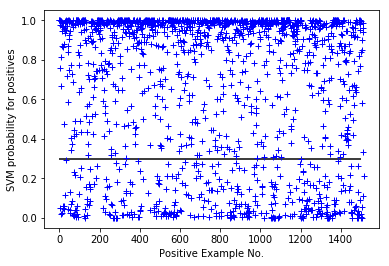

In [84]:
plt.figure(3)
plt.plot(positive_probs_svm, 'b+')
plt.hlines(0.3, 0, 1500)
plt.xlabel('Positive Example No.')
plt.ylabel('SVM probability for positives')

Text(0, 0.5, 'SVM probability for negatives')

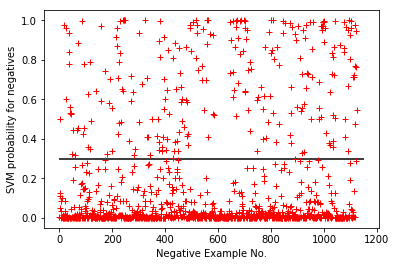

In [85]:
plt.figure(4)
plt.plot(negative_probs_svm, 'r+')
plt.hlines(0.3, 0, 1150)
plt.xlabel('Negative Example No.')
plt.ylabel('SVM probability for negatives')

### Theoretical results
The above results match the theoretical results as shown here: https://scikit-learn.org/stable/modules/calibration.html . The probabilities of the SVM are automatically calibrated when setting flag Probability=True, so there is high confidence near 0 and 1. In contrast, Random Forest probability distrubution theoretically lies around 0.2-0.3 and 0.8-0.9 according to the docs. In our plots we see that indeed for negative examples there is a dense gathering between 0.2 and 0.3, but for positive examples the borders are more spreaded. This is because (I guess) the classifier predicts True more 'easily' duo to the unbalanced dataset. By using a more balanced dataset we will probably see more accurate match with the theoretical results.
All the above state that both of our classifiers are well trained.

### Positive Bias
Our initial dataset consists of 1500 positive examples and 1100 negative examples approximately. That causes the classifiers to bias their predictions towards 1. This is merely fixed by fine tunning the prediction thresholds, so we set 0.4 for RF and 0.3 for SVM. However, if the dataset was more balanced the results could be even better(?).

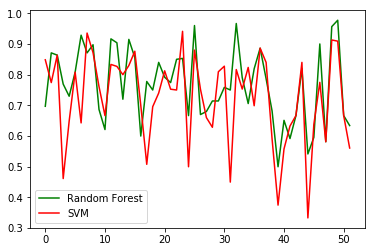

In [31]:
line1, = plt.plot(accuracy_rf_raw, 'g')
line2, = plt.plot(accuracy_svm_raw, 'r')
plt.legend((line1, line2), ("Random Forest", "SVM"))
plt.show()

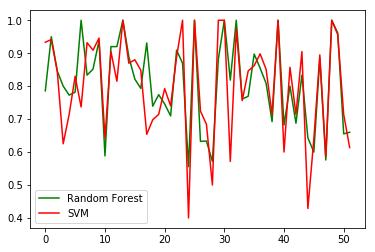

In [32]:
line3, = plt.plot(precision_rf_raw, 'g')
line4, = plt.plot(precision_svm_raw, 'r')
plt.legend((line3, line4), ("Random Forest", "SVM"))
plt.show()

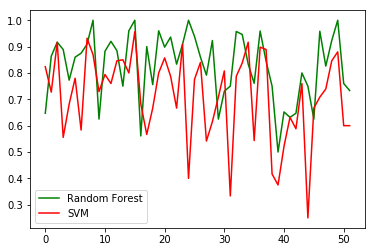

In [33]:
line5, = plt.plot(recall_rf_raw, 'g')
line6, = plt.plot(recall_svm_raw, 'r')
plt.legend((line5, line6), ("Random Forest", "SVM"))
plt.show()